In [1]:
!pip install gym
!pip install gym[all]

     |████████████████████████████████| 450kB 2.8MB/s 
     |████████████████████████████████| 122kB 8.7MB/s 
     |████████████████████████████████| 215kB 10.5MB/s 
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ss9hle5a/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ss9hle5a/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-8j6vw1bf/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [2]:
from keras.layers import  Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import gym

Using TensorFlow backend.


2)a) State and Action space

In [3]:
env = gym.make('LunarLander-v2')
print('action space')
print(env.action_space)
print('observation space')
print(env.observation_space)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


action space
Discrete(4)
observation space
Box(8,)


Random Agent


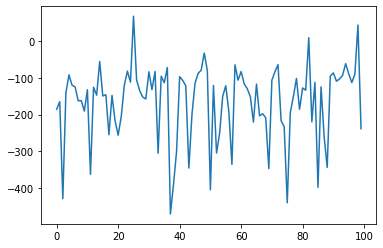

In [4]:
rand_scores = []
for i_episode in range(100):
    observation = env.reset()
    score = 0
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    rand_scores.append(score)
env.close()
x_axis = [i for i in range(100)]
plt.plot(x_axis, rand_scores)
plt.show()

2)b)

In [0]:
n_actions = 4
input_dim = 8
GAMMA = 0.99
MINI_BATCH = 2
n_epsiodes = 2000
layer1_size = 16
layer2_size = 16
lr = 0.005
action_space = [x for x in range(n_actions)]

local_state = []
local_action = []
local_reward = []

batch_state = []
batch_action = []
batch_reward = []

flat_state = []
flat_action = []
flat_reward = []

In [0]:
def get_model():
  main_input = Input(shape=(input_dim,), name='main_input')
  aux_input = Input(shape=[1], name='aux_input')          # A(t)
  dense_1 = Dense(layer1_size, activation='relu')(main_input)
  dense_2 = Dense(layer2_size, activation='relu')(dense_1)
  main_output = Dense(n_actions, activation='softmax', name='main_output')(dense_2)
  # dense_3 = Dense(n_actions, activation=None)(dense_2)
  # main_output = Dense(n_actions, activation='softmax', name='main_output')(dense_3)

  def custom_loss_func(y_true, y_pred):
    pi = K.clip(y_pred, 1e-8, 1-1e-8)    # shape(2,) 
    # pi = K.minimum(y_pred, 1e-8)
    log_prob = y_true*K.log(pi)
    return -K.sum(log_prob*aux_input)

  model = Model(input=[main_input, aux_input], output=[main_output])
  model.compile(optimizer=Adam(lr=lr), loss=custom_loss_func)
  
  return model

In [0]:
def choose_action(observation):
  state = observation[np.newaxis, :]
  g = np.array([0])     # creating g, but its not used in calculation
  p = model.predict([state, g])[0]
  action = np.random.choice(action_space, p=p)
  return action

def flat_memory():
  flat_state = [item for sublist in batch_state for item in sublist]
  flat_action = [item for sublist in batch_action for item in sublist]
  flat_reward = [item for sublist in batch_reward for item in sublist]
  
def batch_memory():
  batch_state.append(local_state)
  batch_action.append(local_action)
  batch_reward.append(local_reward)

def local_memory(observation, action, reward):
  local_state.append(observation)
  local_action.append(action)
  local_reward.append(reward)

def clear_batch_memory():
  batch_state.clear()
  batch_action.clear()
  batch_reward.clear()

def clear_local_memory():
  local_state.clear()
  local_action.clear()
  local_reward.clear()

def learn(rtg=True, advantage=True):
  actions = np.zeros([len(flat_action), n_actions])
  for i in range(len(flat_action)):
    actions[i][flat_action[i]] = 1

  G = np.zeros_like(batch_reward)

  if rtg:
    for k in range(MINI_BATCH):
      G[k][-1] = batch_reward[k][-1]
      for t in reversed(range(0, len(batch_reward[k])-1)):
        G[k][t] = GAMMA * G[k][t+1] + batch_reward[k][t]
  else:
    for k in range(MINI_BATCH):
      g = 0
      for t in reversed(range(0, len(batch_reward[k]))):
        g = GAMMA * g + batch_reward[k][t]
      for t in range(len(batch_reward[k])):
        G[k][t] = g


  if advantage and rtg:
    for k in range(MINI_BATCH):
      mean = np.mean(G[k])
      std = np.std(G[k])
      G[k] = (G[k]-mean)/std

  # flattening G 
  G = [item for sublist in G for item in sublist]

  # mean = np.mean(G)
  # std = np.std(G) if np.std(G) > 0 else 1
  # G = (G-mean)/std
  cost = model.train_on_batch([flat_state, G], actions)


In [0]:
def agent(rtg=True, advantage=True):
  global flat_state, flat_action, flat_reward

  score_history = []
  avg_scores = []
  env = gym.make('LunarLander-v2')
  model = get_model()

  for epsiode in range(n_epsiodes):
    clear_batch_memory()
    score = 0
    for k in range(MINI_BATCH):
      # score = 0
      observation = env.reset()
      clear_local_memory()
      while True:
        action = choose_action(observation)
        observation_new, reward, done, _ = env.step(action)
        local_memory(observation,action, reward)
        observation = observation_new
        score += reward
        if done:
          batch_memory()
          break
      # score_history.append(score)
    flat_state = [item for sublist in batch_state for item in sublist]
    flat_action = [item for sublist in batch_action for item in sublist]
    flat_reward = [item for sublist in batch_reward for item in sublist]
    # flat_memory()
    learn(rtg, advantage)

    # testing after training
    observation = env.reset()
    while True:
      action = choose_action(observation)
      observation, reward, done, _ = env.step(action)
      score += reward
      if done:
        break
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_scores.append(avg_score)
    print('epsiode: {}, score: {}, avg_score: {}'.format(epsiode, score, avg_score))
    if avg_score > 100:
      break

  x_axis = [i for i in range(epsiode+1)]
  plt.plot(x_axis, avg_scores)
  plt.show()


reward-to-go: True

Advantage: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -381.05189519131795, avg_score: -381.05189519131795
epsiode: 1, score: -658.3778229291684, avg_score: -519.7148590602432
epsiode: 2, score: -324.72878067257, avg_score: -454.71949959768546
epsiode: 3, score: -697.3902856580676, avg_score: -515.387196112781
epsiode: 4, score: -561.3627228284915, avg_score: -524.5823014559231
epsiode: 5, score: -1290.9242035640282, avg_score: -652.305951807274
epsiode: 6, score: -891.7372110848708, avg_score: -686.5104174183592
epsiode: 7, score: -657.9749875447804, avg_score: -682.9434886841618
epsiode: 8, score: -613.676558934241, avg_score: -675.2471631563928
epsiode: 9, score: -972.1420150584283, avg_score: -704.9366483465964
epsiode: 10, score: -669.259510527338, avg_score: -701.6932721812092
epsiode: 11, score: -826.2335903619048, avg_score: -712.0716320296006
epsiode: 12, score: -438.01273174366935, avg_score: -690.9901781614519
epsiode: 13, score: -719.8785714248186, avg_score: -693.053634823121
epsiode: 14, score: -807.1610674

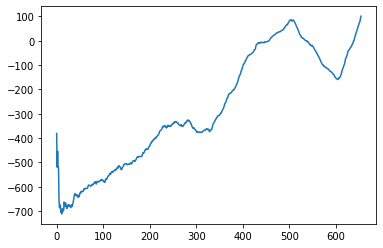

In [9]:
model = get_model()
agent(rtg=True, advantage=True)

reward-to-go: True

Advantage: False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -589.6368403269026, avg_score: -589.6368403269026
epsiode: 1, score: -339.64210081936875, avg_score: -464.63947057313567
epsiode: 2, score: -580.7118394301084, avg_score: -503.33026019212656
epsiode: 3, score: -428.65002661641034, avg_score: -484.6602017981975
epsiode: 4, score: -297.00085522913537, avg_score: -447.1283324843851
epsiode: 5, score: -375.5644202450015, avg_score: -435.2010137778212
epsiode: 6, score: -361.33859154547207, avg_score: -424.6492391731999
epsiode: 7, score: -382.26092858046917, avg_score: -419.3507003491085
epsiode: 8, score: -578.3182273881829, avg_score: -437.0137589090057
epsiode: 9, score: -415.8030012604115, avg_score: -434.8926831441462
epsiode: 10, score: -495.5039794482752, avg_score: -440.40280098997613
epsiode: 11, score: -202.27030565736328, avg_score: -420.5584263789251
epsiode: 12, score: -445.5365770928778, avg_score: -422.47982258769065
epsiode: 13, score: -538.7764430725429, avg_score: -430.7867240508944
epsiode: 14, score: 

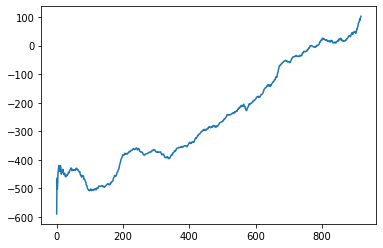

In [10]:
model = get_model()
agent(rtg=True, advantage=False)

reward-to-go: False

Advantage: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -812.2527557106541, avg_score: -812.2527557106541
epsiode: 1, score: -364.6862864252568, avg_score: -588.4695210679555
epsiode: 2, score: -351.4139882462031, avg_score: -509.4510101273713
epsiode: 3, score: -570.0711456752185, avg_score: -524.6060440143331
epsiode: 4, score: -253.1773942887667, avg_score: -470.32031406921976
epsiode: 5, score: -635.9816369513125, avg_score: -497.93053454956856
epsiode: 6, score: -696.3650932457501, avg_score: -526.278328649023
epsiode: 7, score: -619.7798913942046, avg_score: -537.9660239921708
epsiode: 8, score: -643.0060711941975, avg_score: -549.6371403479516
epsiode: 9, score: -480.5459900056012, avg_score: -542.7280253137166
epsiode: 10, score: -425.93531000548444, avg_score: -532.1105057402409
epsiode: 11, score: -586.5817925287981, avg_score: -536.6497796392873
epsiode: 12, score: -267.3744808523727, avg_score: -515.9362951172169
epsiode: 13, score: -393.6223724735172, avg_score: -507.1995863569527
epsiode: 14, score: -297.234

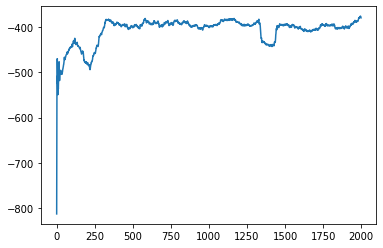

In [11]:
model = get_model()
agent(rtg=False, advantage=True)

reward-to-go: False

Advantage: False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -593.3806904446, avg_score: -593.3806904446
epsiode: 1, score: -253.17512691606024, avg_score: -423.2779086803301
epsiode: 2, score: -302.0569898998195, avg_score: -382.87093575349326
epsiode: 3, score: -489.74435070361886, avg_score: -409.58928949102466
epsiode: 4, score: -344.8267393097916, avg_score: -396.63677945477804
epsiode: 5, score: -564.3400525590473, avg_score: -424.58732497215624
epsiode: 6, score: -328.2131453207825, avg_score: -410.81958502196
epsiode: 7, score: -844.290695510144, avg_score: -465.003473832983
epsiode: 8, score: -677.5891966815636, avg_score: -488.6241097050475
epsiode: 9, score: -607.3847889267228, avg_score: -500.500177627215
epsiode: 10, score: -342.3006794999387, avg_score: -486.1184050701899
epsiode: 11, score: -482.95233279181457, avg_score: -485.8545657136586
epsiode: 12, score: -553.512365916823, avg_score: -491.05901188313277
epsiode: 13, score: -318.1408365453616, avg_score: -478.70771364472057
epsiode: 14, score: -700.51727774

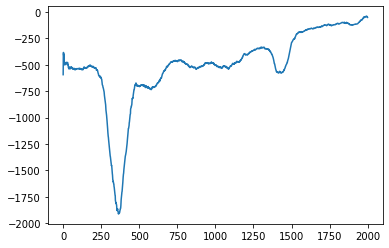

In [12]:
model = get_model()
agent(rtg=False, advantage=False)

3)c) Impact of batch size on policy gradient estimate

Batch size: 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -850.1873403389701, avg_score: -850.1873403389701
epsiode: 1, score: -1021.9631575819058, avg_score: -936.0752489604379
epsiode: 2, score: -1182.1590632843668, avg_score: -1018.1031870684142
epsiode: 3, score: -1557.8189502925352, avg_score: -1153.0321278744445
epsiode: 4, score: -790.7139247839172, avg_score: -1080.568487256339
epsiode: 5, score: -1206.0065469342594, avg_score: -1101.4748305359924
epsiode: 6, score: -984.7162182433626, avg_score: -1084.7950287799024
epsiode: 7, score: -1521.3942077922995, avg_score: -1139.369926156452
epsiode: 8, score: -989.2951506107016, avg_score: -1122.6949510958132
epsiode: 9, score: -1226.5755227442482, avg_score: -1133.0830082606567
epsiode: 10, score: -552.4853957216767, avg_score: -1080.3014071207492
epsiode: 11, score: -452.692683665385, avg_score: -1028.0006801661357
epsiode: 12, score: -1093.4183746198119, avg_score: -1033.0328105087262
epsiode: 13, score: -933.9092166922456, avg_score: -1025.952553807549
epsiode: 14, sc

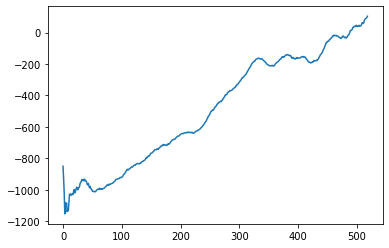

In [13]:
MINI_BATCH = 4
model = get_model()
agent(rtg=True, advantage=True)

Batch size: 16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


epsiode: 0, score: -4771.626351335639, avg_score: -4771.626351335639
epsiode: 1, score: -4654.662745021042, avg_score: -4713.14454817834
epsiode: 2, score: -3663.3430059343664, avg_score: -4363.210700763682
epsiode: 3, score: -3382.385563631473, avg_score: -4118.0044164806295
epsiode: 4, score: -4129.486092212666, avg_score: -4120.300751627037
epsiode: 5, score: -4004.8146348437417, avg_score: -4101.053065496488
epsiode: 6, score: -3693.8801155242754, avg_score: -4042.8855012147433
epsiode: 7, score: -3289.9006045143396, avg_score: -3948.762389127193
epsiode: 8, score: -2873.4845257098686, avg_score: -3829.287070969712
epsiode: 9, score: -2733.745481571891, avg_score: -3719.73291202993
epsiode: 10, score: -3748.4306036895755, avg_score: -3722.3417930898972
epsiode: 11, score: -2588.0500449355336, avg_score: -3627.8174807437003
epsiode: 12, score: -3093.2931276665227, avg_score: -3586.7002228146866
epsiode: 13, score: -3266.320175620092, avg_score: -3563.8159337293587
epsiode: 14, score

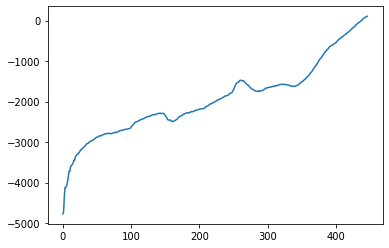

In [14]:
MINI_BATCH = 16
model = get_model()
agent(rtg=True, advantage=True)